In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from gpflow.likelihoods import Gaussian
import tikzplotlib
import gpflow
from markovflow.kernels import OrnsteinUhlenbeck
from docs.sde.sde_exp_utils import get_cvi_gpr, predict_cvi_gpr

2022-08-11 10:04:37.873983: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 10:04:37.874005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-11 10:04:39.110430: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-11 10:04:39.111042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-11 10:04:39.141133: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-11 10:04:39.141193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-11 10:04:39.141209: I tensorflow/stream_execut

In [2]:
seed_id = 33
save_tex = False

main_dir = r"../data/gpu_training/" + str(seed_id)

output_dir = os.path.join(r"output", str(seed_id))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
extra_axis_parameters = ["axis x line=bottom", "axis y line=left"]

In [3]:
## Utility

def lst_to_str(lst):
    return str(lst).replace("[", "{").replace("]", "}")

## Plot Data

In [4]:
data_path = os.path.join(main_dir, "data.npz")
data = np.load(data_path)

In [5]:
decay = data["decay"]
latent_process = data["latent_process"]
noise_var = data["noise_stddev"]**2
q = data["q"]
time_grid = data["time_grid"]
x0 = data["x0"]
observation_data = (data["observation_grid"].reshape((-1,)), data["observation_vals"].reshape((-1, 1)))
test_data = (data["test_grid"].reshape((-1, )), data["test_vals"].reshape((-1, 1)))

t0 = time_grid[0]
t1 = time_grid[-1]

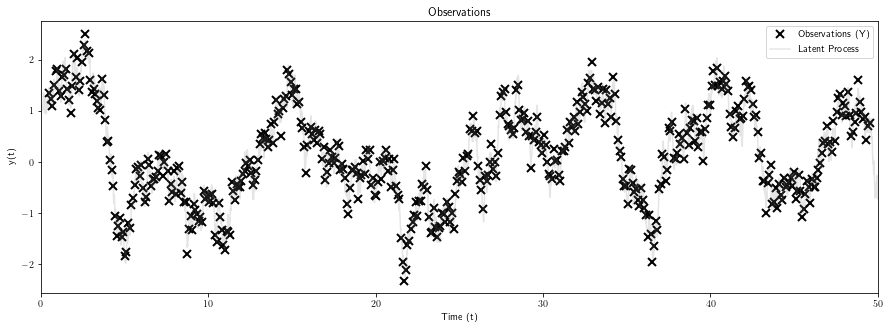

In [6]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(observation_data[0].reshape(-1), observation_data[1].reshape(-1), 
         'kx', ms=8, mew=2, label="Observations (Y)")
plt.plot(time_grid, latent_process.reshape(-1), label="Latent Process", alpha=0.2, color="gray")
# plt.plot(test_data[0].reshape(-1), test_data[1].reshape(-1), 'x', color="red", ms=8, mew=2,
#          label="Test Observations (Y)")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Observations")
plt.legend()
plt.show()

## Perform GPR

In [7]:
likelihood = Gaussian(noise_var)

kernel = OrnsteinUhlenbeck(decay=1, diffusion=q)  # Change this initial value to match with the initial value of other methods
gpflow.set_trainable(kernel.diffusion, False)

cvi_gpr_model, cvi_params = get_cvi_gpr(observation_data, kernel, likelihood, train=True, sites_lr=0.9)
cvi_gpr_elbo = cvi_gpr_model.classic_elbo().numpy().item()

print(f"CVI-GPR ELBO: {cvi_gpr_elbo}")
print(f"CVI-GPR param learnt: {cvi_params[0][-1]}")

2022-08-11 10:04:40.863030: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-11 10:04:42.974674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-11 10:04:43.006153: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz
2022-08-11 10:04:43.288906: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


Need to go one step back!!!
CVI-GPR ELBO values: [<tf.Tensor: shape=(), dtype=float64, numpy=-30733.486449172917>, <tf.Tensor: shape=(), dtype=float64, numpy=-149.8518674645248>, <tf.Tensor: shape=(), dtype=float64, numpy=-149.84094857593539>]
CVI-GPR ELBO: -149.84094857593539
CVI-GPR param learnt: 0.4583817906580009


## Learning

### Plot ELBO

In [8]:
ssm_1_path = os.path.join(main_dir, "learning_0.01", "ssm_elbo.npz")
ssm_5_path = os.path.join(main_dir, "learning_0.005", "ssm_elbo.npz")
ssm_01_path = os.path.join(main_dir, "learning_0.001", "ssm_elbo.npz")

ssm_1_elbo = np.load(ssm_1_path)["elbo"]
ssm_5_elbo = np.load(ssm_5_path)["elbo"]
ssm_01_elbo = np.load(ssm_01_path)["elbo"]

In [9]:
vgp_1_path = os.path.join(main_dir, "learning_0.01", "vgp_elbo.npz")
vgp_5_path = os.path.join(main_dir, "learning_0.005", "vgp_elbo.npz")
vgp_01_path = os.path.join(main_dir, "learning_0.001", "vgp_elbo.npz")

vgp_1_elbo = np.load(vgp_1_path)["elbo"]
vgp_5_elbo = np.load(vgp_5_path)["elbo"]
vgp_01_elbo = np.load(vgp_01_path)["elbo"]

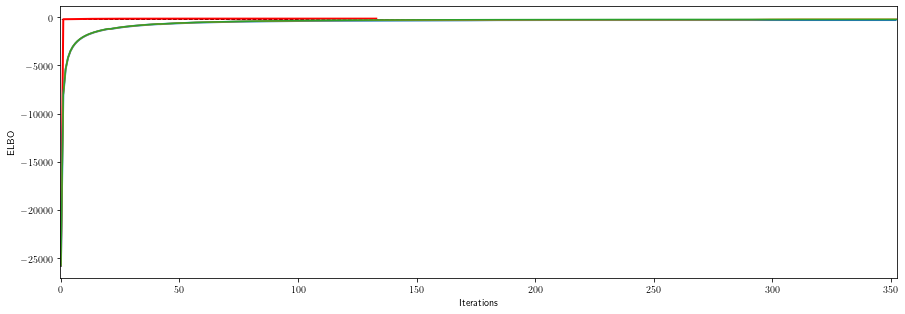

In [10]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(ssm_1_elbo, label="t-VGP (dt=0.01)", linewidth=2., color="red")
# plt.plot(ssm_5_elbo, label="t-VGP (dt=0.005)")
# plt.plot(ssm_01_elbo, label="t-VGP (dt=0.001)")

plt.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
plt.plot(vgp_5_elbo, label="VGP (dt=0.005)")
plt.plot(vgp_01_elbo, label="VGP (dt=0.001)")

plt.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_1_elbo)-1, color="red", linestyle="dashed", linewidth=1.)

plt.hlines(cvi_gpr_elbo, -2, len(vgp_1_elbo)+2, color="black", linestyle="dashed", linewidth=1., label="GPR")

plt.xlabel("Iterations")
plt.ylabel("ELBO")
# plt.legend()
plt.xlim([-0.5, len(vgp_1_elbo)-0.5])
# plt.ylim([-100, -37])

# if seed_id==33:
    

plt.show()

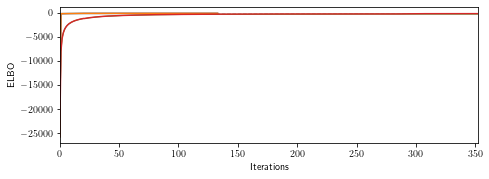

In [11]:
plt.subplots(1, 1, figsize=(7.5, 2.5))

plt.plot(ssm_1_elbo, linewidth=1., color="red")
plt.plot(ssm_5_elbo)
plt.plot(ssm_01_elbo)

plt.plot(vgp_1_elbo, linewidth=1.)
plt.plot(vgp_5_elbo)
# plt.plot(vgp_01_elbo, label="Old method (dt=0.001)")

plt.hlines(cvi_gpr_elbo, -2, len(vgp_1_elbo)+2, color="black", linestyle="dashed", linewidth=1, label="GPR", 
           alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("ELBO")
# plt.ylim([-45, -38])
plt.xlim([0, len(vgp_1_elbo)-.5])
plt.show()



## Plot Prior Learning

In [12]:
ssm_1_sde_path = os.path.join(main_dir, "learning_0.01", "ssm_learnt_sde.npz")
ssm_5_sde_path = os.path.join(main_dir, "learning_0.005", "ssm_learnt_sde.npz")
ssm_01_sde_path = os.path.join(main_dir, "learning_0.001", "ssm_learnt_sde.npz")

ssm_1_sde = np.load(ssm_1_sde_path)["decay"]
ssm_5_sde = np.load(ssm_5_sde_path)["decay"]
ssm_01_sde = np.load(ssm_01_sde_path)["decay"]

In [13]:
vgp_1_sde_path = os.path.join(main_dir, "learning_0.01", "vgp_learnt_sde.npz")
vgp_5_sde_path = os.path.join(main_dir, "learning_0.005", "vgp_learnt_sde.npz")
vgp_01_sde_path = os.path.join(main_dir, "learning_0.001", "vgp_learnt_sde.npz")

vgp_1_sde = np.load(vgp_1_sde_path)["decay"]
vgp_5_sde = np.load(vgp_5_sde_path)["decay"]
vgp_01_sde = np.load(vgp_01_sde_path)["decay"]

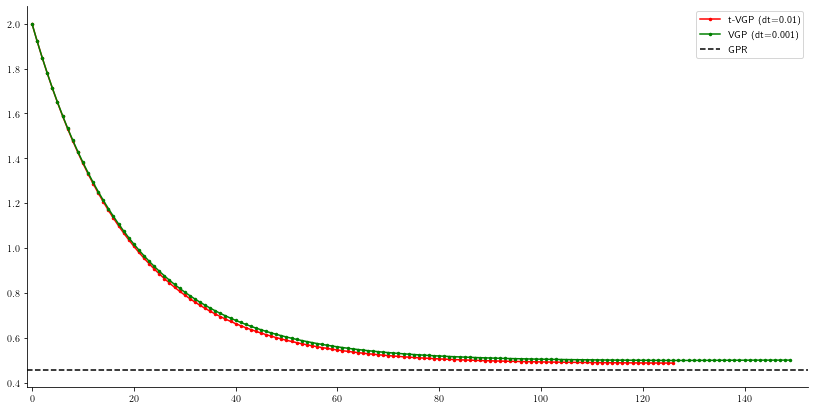

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(14, 7))

axs.plot(-1 * ssm_1_sde, ".-", label="t-VGP (dt=0.01)", markersize=3, markeredgewidth=2., color="red")
# plt.plot(ssm_5_sde, "x", label="Proposed method (dt=0.005)")
# plt.plot(ssm_01_sde, "x", label="Proposed method (dt=0.001)")

# axs.plot(vgp_1_sde, ".-", label="Old method (dt=0.01)", markersize=6, markeredgewidth=2.)
# axs.plot(vgp_5_sde, ".-", label="Old method (dt=0.005)", markersize=6, markeredgewidth=2.)
axs.plot(-1 * vgp_01_sde, ".-", label="VGP (dt=0.001)", markersize=3, markeredgewidth=2., color="green")

axs.hlines(cvi_params[0][-1], -1, len(vgp_1_sde) + 2, color="black", linestyle="dashed", label="GPR")
# plt.yticks([-0.2, -0.4, -0.6])

# axs.set_xlabel("Iterations", fontdict={'fontsize': plots_font_size})
# axs.set_ylabel("$\\alpha$", fontdict={'fontsize': plots_font_size})
# axs.tick_params(axis = 'both', which = 'major', labelsize = plots_font_size)
# axs.tick_params(axis = 'both', which = 'minor', labelsize = plots_font_size)

plt.xlim([-1, len(vgp_1_sde) + .5])
# plt.grid(True)
plt.legend()
# Hide the right and top spines
axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)
# plt.yticks([0.5, 1.0, 1.5, 2.0])
# plt.xticks([0, 4, 8,12,16])

plt.show()

## Plot M-iterations

In [15]:
ssm_1_m_path = os.path.join(main_dir, "learning_0.01", "ssm_m_step.npz")
# ssm_5_m_path = os.path.join(main_dir, "learning_0.005", "ssm_m_step.npz")
# ssm_01_m_path = os.path.join(main_dir, "learning_0.001", "ssm_m_step.npz")

ssm_1_m_data = np.load(ssm_1_m_path)["vals"]
# ssm_5_m_data = np.load(ssm_5_m_path)["vals"]
# ssm_01_m_data = np.load(ssm_01_m_path)["vals"]

In [16]:
vgp_1_m_path = os.path.join(main_dir, "learning_0.01", "vgp_m_step.npz")
vgp_5_m_path = os.path.join(main_dir, "learning_0.005", "vgp_m_step.npz")
vgp_01_m_path = os.path.join(main_dir, "learning_0.001", "vgp_m_step.npz")


vgp_1_m_data = np.load(vgp_1_m_path)["vals"]
vgp_5_m_data = np.load(vgp_5_m_path)["vals"]
vgp_01_m_data = np.load(vgp_01_m_path)["vals"]

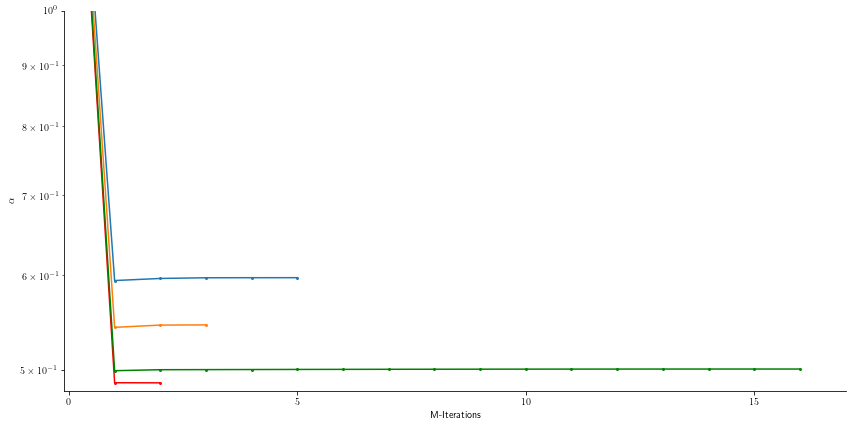

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(14, 7))

axs.plot(-1 * ssm_1_m_data, ".-", label="t-VGP (dt=0.01)", markersize=2, markeredgewidth=2., color="red")
# axs.hlines(-1 * ssm_1_m_data[-1], len(ssm_1_m_data)-1, len(vgp_01_m_data)-1, 
#            color="red", linestyle="dashed", alpha=0.5)

axs.plot(-1 * vgp_1_m_data, ".-", label="VGP (dt=0.01)", markersize=2, markeredgewidth=2.)
axs.plot(-1 * vgp_5_m_data, ".-", label="VGP (dt=0.005)", markersize=2, markeredgewidth=2.)
axs.plot(-1 * vgp_01_m_data, ".-", label="VGP (dt=0.001)", markersize=2, markeredgewidth=2., color="green")

plt.yscale("log")

# axs.hlines(cvi_params[0][-1], -1, len(vgp_1_sde) + 2, color="black", linestyle="dashed", label="GPR")

axs.set_xlabel("M-Iterations")
axs.set_ylabel("$\\alpha$")
axs.tick_params(axis = 'both', which = 'major')
axs.tick_params(axis = 'both', which = 'minor')

axis_parameters = extra_axis_parameters.copy()

if seed_id == 66:
    x_ticks = [0, 2, 4]
    y_ticks = [0.6, 1.2, 1.8]
elif seed_id == 33:
    x_ticks = [0, 5, 10, 15, 20]
    y_ticks = [0.5, 1.0, 1.5, 2.0]

axis_parameters.append("xtick=" + lst_to_str(x_ticks))
axis_parameters.append("ytick=" + lst_to_str(y_ticks))

plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.xlim([-0.1, len(vgp_01_m_data)])
plt.ylim([0.48, 1.0])

# plt.legend()

axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)

# if save_tex:
tikzplotlib.save(os.path.join(output_dir, 'm_step.tex'), figure=fig, axis_width="\\figurewidth",
                 axis_height="\\figureheight", extra_axis_parameters=axis_parameters)

plt.show()